In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense


In [3]:
# Create images with white backgrounds
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fid = drive.ListFile({'q':"title='DATA.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('DATA.zip')

In [8]:
!unzip DATA.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATA/20/Undamage/20_original_104.jpg_9b4f810a-8baa-4b46-9388-fd8679707081.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_7d6afb3b-d55d-4367-99a4-bf34d5b0bcde.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_7eed3cb5-ff8b-485c-853c-91f258928bb3.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_9abe295c-047a-47c6-b7d3-c9a3f7dcea0b.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_defc6234-e1c1-4a2f-968a-6fa36b6d6310.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_3fb75a03-0995-40e8-ab9f-895c2ef7a7f8.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_9bcf9ec5-c048-4a80-90bb-09463d13ad89.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_ca6fa753-dde5-4bcd-8ae3-236832872b9e.jpg  
  inflating: DATA/20/Undamage/20_original_107.jpg_7aaf5559-2bcf-4aab-94ba-e05428f4dbbe.jpg  
  inflating: DATA/20/Undamage/20_original_108.jpg_4cf70d7b-bbaa-4ba3-a902-bffff64d4f03.jpg  
  inflating: DATA/2

In [9]:
PATH = '/content/DATA'

In [10]:
IMG_HEIGHT = 212
IMG_WIDTH = 212
batch_size = 32


In [11]:
# Image preprocessing
image_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of data for validation
)


In [12]:
# Data generators for training and validation
train_data_gen = image_gen.flow_from_directory(
    directory=PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset='training'  # This will use the training split
)

val_data_gen = image_gen.flow_from_directory(
    directory=PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset='validation'  # This will use the validation split
)

Found 9887 images belonging to 4 classes.
Found 2471 images belonging to 4 classes.


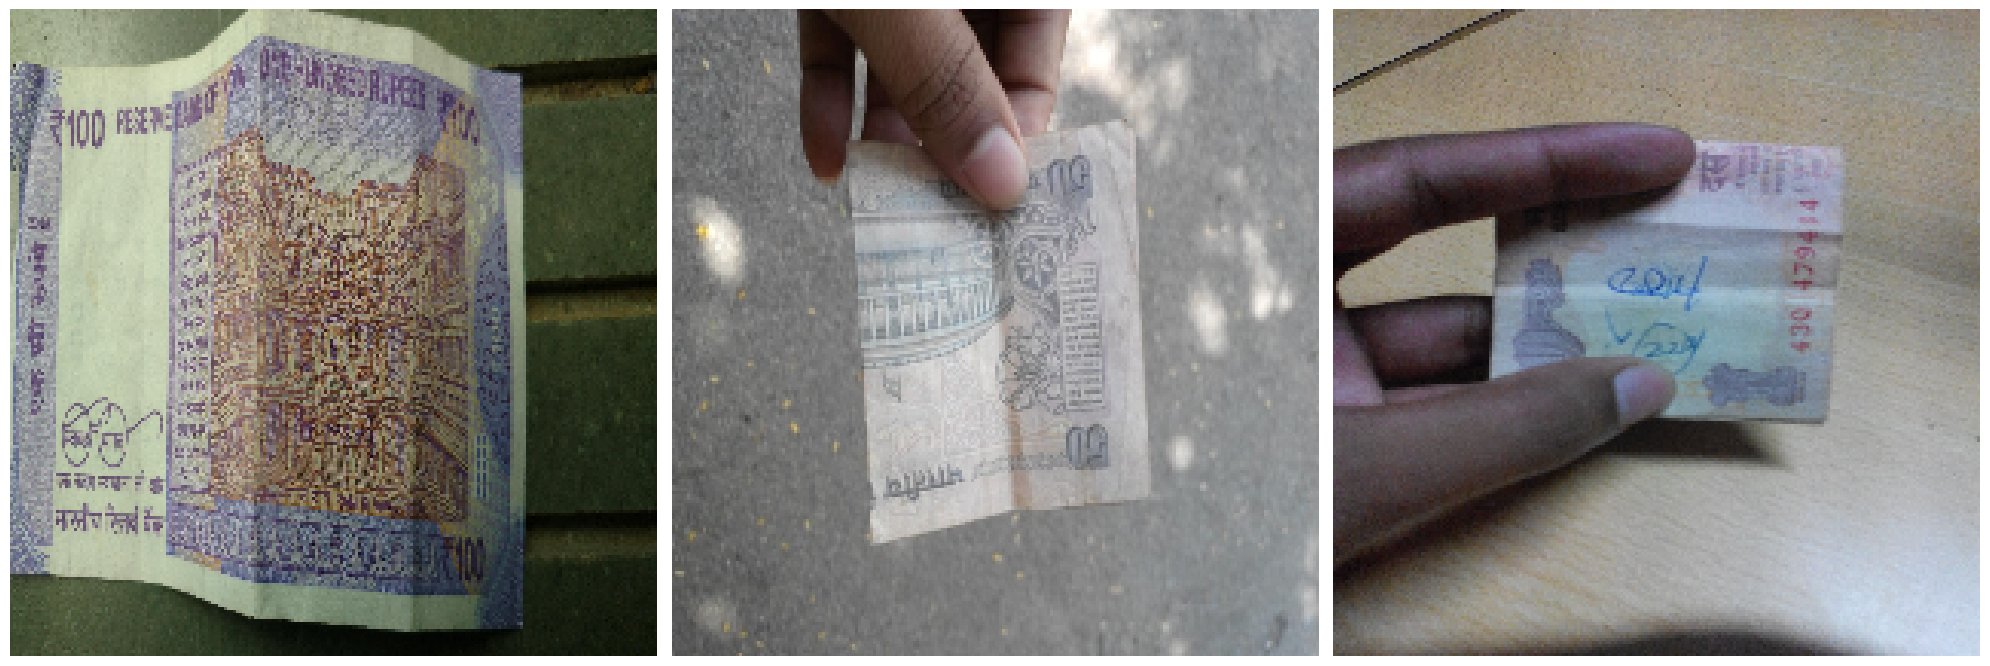

In [14]:
# Visualize sample training images
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[1:5])

In [17]:
# Model definition
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Shared convolutional base
x = Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

In [18]:

# Denomination classification output
denomination_output = Dense(512, activation='relu')(x)
denomination_output = Dense(4, activation='softmax', name='denomination_output')(denomination_output)


In [19]:
# Damage detection output
damage_output = Dense(128, activation='relu')(x)
damage_output = Dense(1, activation='sigmoid', name='damage_output')(damage_output)


In [20]:

# Compile the model
model = Model(inputs=inputs, outputs=[denomination_output, damage_output])

model.compile(
    optimizer='adam',
    loss={
        'denomination_output': 'categorical_crossentropy',
        'damage_output': 'binary_crossentropy'
    },
    metrics={
        'denomination_output': 'accuracy',
        'damage_output': 'accuracy'
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 212, 212, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 212, 212, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 106, 106, 16)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 106, 106, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 106, 106, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 53, 53, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 53, 53, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 26, 26, 64)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 26, 26, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 26, 26, 128)    │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 13, 13, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 13, 13, 128)    │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 21632)          │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │     11,076,096 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │      2,769,024 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ denomination_output       │ (None, 4)              │          2,052 │ dense[0][0]            │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ damage_output (Dense)     │ (None, 1)              │            129 │ dense_1[0][0]          │
└──────────────────────

 Total params: 13,944,741 (53.19 MB)

 Trainable params: 13,944,741 (53.19 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
epochs = 20

history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=7
    )]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


309/309 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - denomination_output_accuracy: 0.3201 - loss: 0.5967 - val_denomination_output_accuracy: 0.3286 - val_loss: 0.5630
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 916s 3s/step - denomination_output_accuracy: 0.5469 - loss: 0.4223 - val_denomination_output_accuracy: 0.4128 - val_loss: 0.6146
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 916s 3s/step - denomination_output_accuracy: 0.6339 - loss: 0.3567 - val_denomination_output_accuracy: 0.4407 - val_loss: 0.7218
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 918s 3s/step - denomination_output_accuracy: 0.7100 - loss: 0.3021 - val_denomination_output_accuracy: 0.4658 - val_loss: 0.7590
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - denomination_output_accuracy: 0.7889 - loss: 0.2406 - val_denomination_output_accuracy: 0.4411 - val_loss: 0.8161
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 884s 3s/step - denomination_output_accuracy: 0.8467 - loss: 0.1823 - val_denomination_output_accuracy: 0.4047 - val_loss: 1.18

In [22]:
import matplotlib.pyplot as plt

# 1. Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['denomination_output_accuracy'], label='Training Accuracy (Denomination)')
    plt.plot(history.history['val_denomination_output_accuracy'], label='Validation Accuracy (Denomination)')
    plt.title('Denomination Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_accuracy(history)


In [23]:

# Grad-CAM function (same as before)
import cv2

In [53]:
def grad_cam(model, img_array, layer_name, label_index):
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output[0]]  # Denomination output (first output)
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Ensure we are selecting the correct output for the denomination prediction
        loss = predictions[:, label_index]  # Here, label_index corresponds to the denomination classes (0, 1, 2, or 3)

    # Compute the gradients
    grads = tape.gradient(loss, conv_outputs)
    # Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the feature map by the pooled gradients
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()  # Return the heatmap as a NumPy array


In [54]:
# Load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

In [55]:
# Example usage
img_path = '/content/DATA/20/Damage/20_new_103.jpg'  # Change this path accordingly
img_array = load_and_preprocess_image(img_path)

In [56]:

# Generate Grad-CAM
layer_name = 'conv2d_3'  # The last convolutional layer
heatmap = grad_cam(model, img_array, layer_name, label_index=0)  # Damage detection index


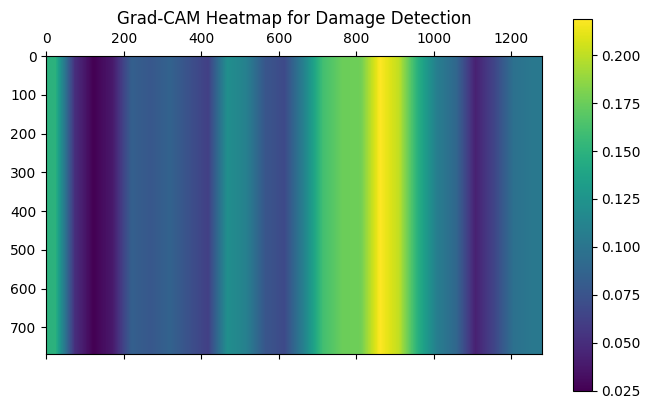

In [61]:
# If the heatmap has more than 2 dimensions, reduce it to 2D by averaging across the channels
if heatmap.ndim == 3:
    heatmap = np.mean(heatmap, axis=-1)  # Average over the channels

# Ensure the heatmap is 2D by removing the extra dimension if necessary
heatmap = heatmap.squeeze()

# Display the heatmap
plt.matshow(heatmap, cmap='viridis')
plt.colorbar()
plt.title('Grad-CAM Heatmap for Damage Detection')
plt.show()



In [62]:
# Overlay heatmap on image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

In [63]:

from google.colab.patches import cv2_imshow


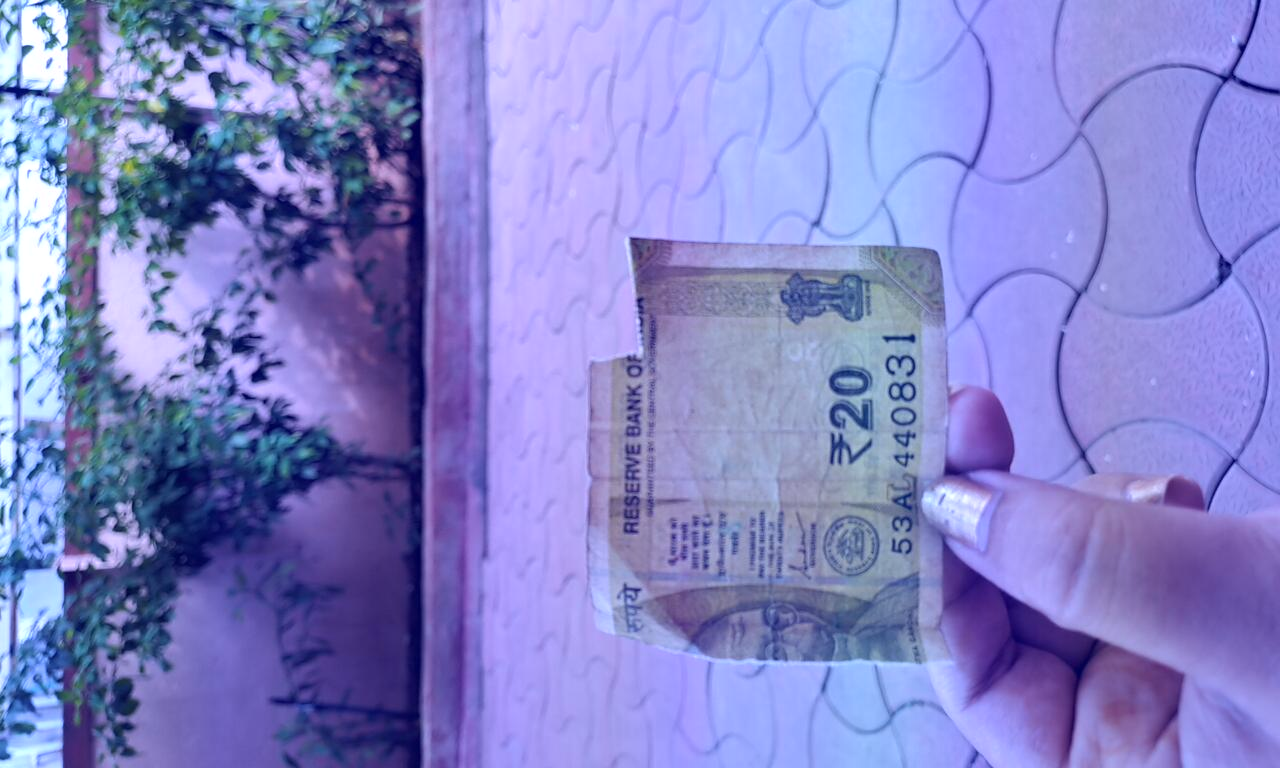

-1

In [64]:

superimposed_img = heatmap * 0.4 + img
cv2_imshow(superimposed_img)
cv2.waitKey(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


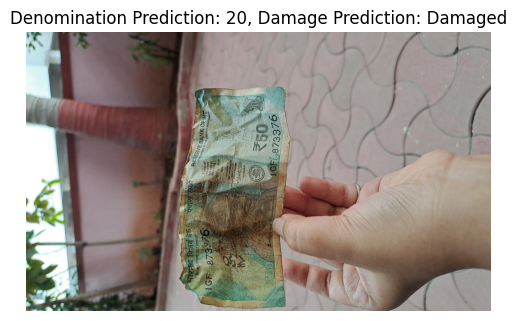

In [69]:
def display_single_prediction(model, img_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Get predictions for the single image
    predictions = model.predict(img_array)

    # Get the predicted index for denomination (7 classes)
    denomination_pred_index = np.argmax(predictions[0], axis=-1).item()  # Ensure it's a scalar

    # Map the predicted index to the actual denomination
    denomination_mapping = [10, 20, 50, 100, 200, 500, 2000]  # Adjust if needed
    denomination_pred = denomination_mapping[denomination_pred_index]

    # Get the binary prediction for damage
    damage_pred = predictions[1].squeeze()  # Binary prediction for damage

    # Display the image and predictions
    img = cv2.imread(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Damage status (Undamaged or Damaged)
    damage_status = "Damaged" if damage_pred > 0.5 else "Undamaged"
    plt.title(f'Denomination Prediction: {denomination_pred}, Damage Prediction: {damage_status}')
    plt.show()

    # Visualize Grad-CAM for the current image
    layer_name = 'conv2d_3'  # Use the correct layer name from your model
    heatmap = grad_cam(model, img_array, layer_name=layer_name, label_index=denomination_pred_index)


# Example usage: Display prediction and Grad-CAM for a specific image
img_path = '/content/DATA/50/Damage/50_new_1.jpg'
display_single_prediction(model, img_path)
